# Antarctic SMB trends with sea level pressure and temperature trends

Author: Ziqi Yin

Last edited: Feb 10, 2025

## Description

- Data: MT19; CESM2-LEcmip6
    - MT19: SMB reconstruction of Medley and Thomas, 2019
    - OC24: surface sea level pressure reconstruction
    - OC21: surface air temperature reconstruction
    - CESM2-LEcmip6: Large Ensemble (LE) using the 50 members that have original CMIP6 biomass burning aerosols
- Period: 1901-2000

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
import matplotlib.path as mpath
import matplotlib.colors as colors

import sys  
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
### --- Plot basemap of Antarctica with cartopy --- ###
def plot_antarctica_SO(ax, lat):
    coast_line = gpd.read_file('/glade/work/ziqiyin/shp_files/Coastline_Antarctica_v2.shp')
    grounding_line = gpd.read_file('/glade/work/ziqiyin/shp_files/GroundingLine_Antarctica_v2.shp')
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax.add_geometries(coast_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    #ax.add_geometries(grounding_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='white', edgecolor='black', linewidth = 0.5)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, lat], ccrs.PlateCarree())
    return

## Read data

In [3]:
## SMB variables
# MT19 Reconstructions (1801-2000)
#path = '/glade/work/dschneid/zaria_snow/'

#fn_SMB_MT = 'merra_medley_regrid.nc'
#SMB_MT = xr.open_dataset(path+fn_SMB_MT).smb #Fig.3a
#lat_MT = np.array(SMB_MT.lat)
#lon_MT = np.array(SMB_MT.lon)

# CESM2-LEcmip6 ensemble #040
#path = '/glade/work/ziqiyin/2023-AIS-SMB-CESM2/'

#SMB_LE40_yearly = xr.open_dataset(path+'SMB_LEcmip6_ensemble_yearly.nc').SMB.sel(num=40) #[mm/yr], Fig.3b

# CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_RAIN_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.RAIN.185001-210012.nc'
RAIN_LE = xr.open_dataset(path+fn_RAIN_LE).RAIN #[mm/s]
lon = RAIN_LE.lon
lat = RAIN_LE.lat
fn_SNOW_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.SNOW.185001-210012.nc'
SNOW_LE = xr.open_dataset(path+fn_SNOW_LE).SNOW
fn_QSOIL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QSOIL.185001-210012.nc'
QSOIL_LE = xr.open_dataset(path+fn_QSOIL_LE).QSOIL
fn_QRUNOFF_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QRUNOFF.185001-210012.nc'
QRUNOFF_LE = xr.open_dataset(path+fn_QRUNOFF_LE).QRUNOFF
SMB_LE = RAIN_LE + SNOW_LE - QSOIL_LE - QRUNOFF_LE #Fig.3c

In [4]:
## SMB trend
# MT19 (provided by Dave)
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn_MT = 'MT19_congruent_with_zonal_wind_trend.nc'
SMB_trend_MT = xr.open_dataset(path+fn_MT).MT19_linear_trend #[mm/yr*100yr], Fig.3a
SMB_trend_MT_u = xr.open_dataset(path+fn_MT).MT19_trend_congruent_with_zonal_wind_trend #Fig.3e
SMB_trend_MT_res = xr.open_dataset(path+fn_MT).MT19_residual_trend #Fig.3g
lat_MT = np.array(SMB_trend_MT.lat)
lon_MT = np.array(SMB_trend_MT.lon)

# CESM2-LEcmip6 ensemble #040 (provided by Dave)
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn_LE40 = 'CESM2_LEcmip6_1281_10_congruent_with_zonal_wind_trend.nc'
SMB_trend_LE40 = xr.open_dataset(path+fn_LE40).CESM2_LEcmip6_1281_10_SMB_linear_trend #[hPa/100yr], Fig.3b
SMB_trend_LE40_u = xr.open_dataset(path+fn_LE40).CESM2_LEcmip6_1281_10_SMB_congruent_with_zonal_wind_trend #Fig.3f, same to the file 'CESM2_LEcmip6_1281_10_congruent_with_zonal_wind_trend.nc'
SMB_trend_LE40_res = xr.open_dataset(path+fn_LE40).residual_SMB_CESM2_017 #Fig.3h

In [5]:
## PSL
# O'Connor reconstruction (1850-2005)
#path = '/glade/work/dschneid/oconnor/'

##fn_PSL_OC = 'lens_recon_psl_1900_2005_ens_mean.nc' # version 1 - O'Connor21
#fn_PSL_OC = 'LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom_psl.nc' # version 2 - O'Connor24
##fn_PSL_OC = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom_psl.nc' # version 3 - O'Connor24-TPACE
#PSL_OC = xr.open_dataset(path+fn_PSL_OC).psl[:,0,:,:] #[Pa]
#lat_OC = np.array(PSL_OC.lat)
#lon_OC = np.array(PSL_OC.lon)

# CESM2-LEcmip6 ensemble #040
#path = '/glade/work/ziqiyin/2023-AIS-SMB-CESM2/'

#PSL_LE40_yearly = xr.open_dataset(path+'PSL_LEcmip6_ensemble_yearly.nc').PSL.sel(num=40) #[Pa], Fig.3b

#CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_PSL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.cam.h0.PSL.185001-210012.nc'
PSL_LE = xr.open_dataset(path+fn_PSL_LE).PSL #[Pa], Fig.3c

In [6]:
## PSL trend
# OC24 (provided by Dave)
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn = 'OC24_SLP_OC21TAS_congruent_with_zonal_wind_trend.nc'
PSL_trend_OC24 = xr.open_dataset(path+fn).linear_trend_SLP_OC24 #[hPa/100yr], Fig.3a
PSL_trend_OC24_u = xr.open_dataset(path+fn).congruent_SLP_OC24 #Fig.3e, same to the file 'OC24_SLP_congruent_with_zonal_wind_trend.nc'
PSL_trend_OC24_res = xr.open_dataset(path+fn).residual_SLP_OC24 #Fig.3g
lat_OC = np.array(PSL_trend_OC24.lat)
lon_OC = np.array(PSL_trend_OC24.lon)

# CESM2-LEcmip6 ensemble #040 (provided by Dave)
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn_LE40 = 'CESM2_LEcmip6_1281_10_congruent_with_zonal_wind_trend.nc'
PSL_trend_LE40 = xr.open_dataset(path+fn_LE40).CESM2_LEcmip6_1281_10_SLP_linear_trend #[hPa/100yr], Fig.3b
PSL_trend_LE40_u = xr.open_dataset(path+fn_LE40).congruent_SLP_CESM2_LEcmip6_1281_10 #Fig.3f, same to the file 'CESM2-LEcmip6_1281_10_SLP_congruent_with_zonal_wind_trend.nc'
PSL_trend_LE40_res = xr.open_dataset(path+fn_LE40).CESM2_LEcmip6_1281_10_SLP_residual_trend #Fig.3h

In [7]:
## SST/SAT
# CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_SAT_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.cam.h0.TREFHT.185001-210012.nc'
SAT_LE = xr.open_dataset(path+fn_SAT_LE).TREFHT #[K], Fig.3c

In [8]:
## SST/SAT trend
# OC24 (provided by Dave)
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn = 'OC24_SLP_OC21TAS_congruent_with_zonal_wind_trend.nc'
SAT_trend_OC21 = xr.open_dataset(path+fn).linear_trend_TAS_OC21 #[deg C/100yr], Fig.3a
SAT_trend_OC21_u = xr.open_dataset(path+fn).congruent_TAS_OC21 #Fig.3e
SAT_trend_OC21_res = xr.open_dataset(path+fn).residual_TAS_OC21 #Fig.3g

# CESM2-LEcmip6 ensemble #040 (provided by Dave)
path = '/glade/work/dschneid/zaria_snow/revision1/'

fn_LE40 = 'CESM2_LEcmip6_1281_10_congruent_with_zonal_wind_trend.nc'
SAT_trend_LE40 = xr.open_dataset(path+fn_LE40).CESM2_LEcmip6_1281_10_SAT_linear_trend #[deg C/100yr], Fig.3b
SAT_trend_LE40_u = xr.open_dataset(path+fn_LE40).congruent_SAT_CESM2_LEcmip6_1281_10 #Fig.3f, same to the file 'CESM2-LEcmip6_1281_10_SLP_congruent_with_zonal_wind_trend.nc'
SAT_trend_LE40_res = xr.open_dataset(path+fn_LE40).CESM2_LEcmip6_1281_10_SAT_residual_trend #Fig.3h

In [9]:
## Zwally grounded ice sheet land mask (REMOVAL of ice shelves)
path = '/glade/work/dschneid/zaria_snow/'

fn_GROUNDEDMASK = 'AIS_Groundedmask_Zwally_CESMgrid.nc'
GROUNDEDMASK = xr.open_dataset(path+fn_GROUNDEDMASK).Groundedmask

# Select lat range
#GROUNDEDMASK_sel = GROUNDEDMASK.sel(lat=slice(-90,-60))

# Rearrange the longitude for MT19, from [0~360] to [-180~180]
#GROUNDEDMASK_sel_lon_new = GROUNDEDMASK_sel.lon.where(GROUNDEDMASK_sel.lon<=180, GROUNDEDMASK_sel.lon-360)
#GROUNDEDMASK_sel['lon'] = GROUNDEDMASK_sel_lon_new
#GROUNDEDMASK_sel_rearrange = GROUNDEDMASK_sel.sortby(GROUNDEDMASK_sel.lon)
# Note: in the calculation below, GROUNDEDMASK_sel_rearrange also needs to be add with ".values" since its lat values are not exactly the same to those in SMB_MT

In [10]:
## Correct time
dates = pd.date_range("1850-01-01", periods=251*12, freq='ME')
SMB_LE['time'] = dates
PSL_LE['time'] = dates
SAT_LE['time'] = dates

In [11]:
## Select time period
#SMB_MT = SMB_MT.sel(year=slice("1901", "2001"))
SMB_LE = SMB_LE.sel(time=slice("1901-01-01", "2000-12-31"))

#PSL_OC = PSL_OC.sel(time=slice("1901", "2000"))
PSL_LE = PSL_LE.sel(time=slice("1901-01-01", "2000-12-31"))
SAT_LE = SAT_LE.sel(time=slice("1901-01-01", "2000-12-31"))

## Calculate

In [12]:
## Calculate yearly mean SMB over the grounded ice sheet

#SMB_MT_yearly = SMB_MT * GROUNDEDMASK_sel_rearrange.values

days_in_month = SMB_LE.time.dt.days_in_month
year = SMB_LE.time.dt.year
SMB_LE_monthly = SMB_LE #[mm/s]
SMB_LE_yearly = (SMB_LE_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

In [13]:
## Calculate yearly mean PSL

# Plot period 1901-2000
#PSL_OC_yearly = PSL_OC

days_in_month = PSL_LE.time.dt.days_in_month
year = PSL_LE.time.dt.year
PSL_LE_monthly = PSL_LE #[Pa]
PSL_LE_yearly = (PSL_LE_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

In [14]:
## Calculate yearly mean SAT

# Plot period 1901-2000
days_in_month = SAT_LE.time.dt.days_in_month
year = SAT_LE.time.dt.year
SAT_LE_monthly = SAT_LE #[K]
SAT_LE_yearly = (SAT_LE_monthly * days_in_month).groupby(year).sum() /365 #[K]

In [15]:
##Linear Regression of SMB
        
#MT19, 1901-2000
#year = np.arange(1901, 2001)
#slope_SMB_MT_1901_2000 = SMB_MT_yearly[0,:,:]*0

#for i in range(len(lat_MT)):
#    for j in range(len(lon_MT)):
#        slope, intercept, r, p, se = linregress(year, SMB_MT_yearly[:,i,j])
#        slope_SMB_MT_1901_2000[i,j] = slope

#CESM2-LE cmip6 members, 1901-1970
year = np.arange(1901, 2001)
slope_SMB_LE_1901_2000 = SMB_LE_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_LE_yearly.sel(year=slice("1901","2000"))[:,i,j])
        slope_SMB_LE_1901_2000[i,j] = slope

#CESM2-LE cmip6 #040, 1901-2000
#year = np.arange(1901, 2001)
#slope_SMB_LE40_1901_2000 = SMB_LE40_yearly[0,:,:]*0

#for i in range(192):
#    for j in range(288):
#        slope, intercept, r, p, se = linregress(year, SMB_LE40_yearly.sel(year=slice("1901","2000"))[:,i,j])
#        slope_SMB_LE40_1901_2000[i,j] = slope

In [16]:
##Linear Regression of PSL
#OC24
#year = np.arange(1901, 2001)
#slope_PSL_OC_1901_2000 = PSL_OC_yearly[0,:,:]*0

#for i in range(len(lat_OC)):
#    for j in range(len(lon_OC)):
#        slope, intercept, r, p, se = linregress(year, PSL_OC_yearly[:,i,j])
#        slope_PSL_OC_1901_2000[i,j] = slope

#CESM2-LE cmip6 members
year = np.arange(1901, 2001)
slope_PSL_LE_1901_2000 = PSL_LE_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, PSL_LE_yearly[:,i,j])
        slope_PSL_LE_1901_2000[i,j] = slope

#CESM2-LE cmip6 #040, 1901-2000
#year = np.arange(1901, 2001)
#slope_PSL_LE40_1901_2000 = PSL_LE40_yearly[0,:,:]*0

#for i in range(192):
#    for j in range(288):
#        slope, intercept, r, p, se = linregress(year, PSL_LE40_yearly.sel(year=slice("1901","2000"))[:,i,j])
#        slope_PSL_LE40_1901_2000[i,j] = slope

In [17]:
##Linear Regression of SAT
#CESM2-LE cmip6 members
year = np.arange(1901, 2001)
slope_SAT_LE_1901_2000 = SAT_LE_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SAT_LE_yearly[:,i,j])
        slope_SAT_LE_1901_2000[i,j] = slope

In [18]:
##Add cyclic points
SMB_trend_MT_full, lon_MT_full = add_cyclic_point(SMB_trend_MT, coord=lon_MT)
SMB_trend_LE40_full, lon_full = add_cyclic_point(SMB_trend_LE40, coord=lon)
slope_SMB_LE_1901_2000_full, lon_full = add_cyclic_point(slope_SMB_LE_1901_2000, coord=lon)
SMB_trend_MT_u_full, lon_MT_full = add_cyclic_point(SMB_trend_MT_u, coord=lon_MT)
SMB_trend_LE40_u_full, lon_full = add_cyclic_point(SMB_trend_LE40_u, coord=lon)
SMB_trend_MT_res_full, lon_MT_full = add_cyclic_point(SMB_trend_MT_res, coord=lon_MT)
SMB_trend_LE40_res_full, lon_full = add_cyclic_point(SMB_trend_LE40_res, coord=lon)
slope_SMB_LE_1901_2000_full = np.where(slope_SMB_LE_1901_2000_full != 0, slope_SMB_LE_1901_2000_full, np.NaN)

SAT_trend_OC21_full, lon_OC_full = add_cyclic_point(SAT_trend_OC21, coord=lon_OC)
SAT_trend_LE40_full, lon_full = add_cyclic_point(SAT_trend_LE40, coord=lon)
slope_SAT_LE_1901_2000_full, lon_full = add_cyclic_point(slope_SAT_LE_1901_2000, coord=lon)
SAT_trend_OC21_u_full, lon_OC_full = add_cyclic_point(SAT_trend_OC21_u, coord=lon_OC)
SAT_trend_LE40_u_full, lon_full = add_cyclic_point(SAT_trend_LE40_u, coord=lon)
SAT_trend_OC21_res_full, lon_OC_full = add_cyclic_point(SAT_trend_OC21_res, coord=lon_OC)
SAT_trend_LE40_res_full, lon_full = add_cyclic_point(SAT_trend_LE40_res, coord=lon)

PSL_trend_OC24_full, lon_OC_full = add_cyclic_point(PSL_trend_OC24, coord=lon_OC)
PSL_trend_LE40_full, lon_full = add_cyclic_point(PSL_trend_LE40, coord=lon)
slope_PSL_LE_1901_2000_full, lon_full = add_cyclic_point(slope_PSL_LE_1901_2000, coord=lon)
PSL_trend_OC24_u_full, lon_OC_full = add_cyclic_point(PSL_trend_OC24_u, coord=lon_OC)
PSL_trend_LE40_u_full, lon_full = add_cyclic_point(PSL_trend_LE40_u, coord=lon)
PSL_trend_OC24_res_full, lon_OC_full = add_cyclic_point(PSL_trend_OC24_res, coord=lon_OC)
PSL_trend_LE40_res_full, lon_full = add_cyclic_point(PSL_trend_LE40_res, coord=lon)

## Plot

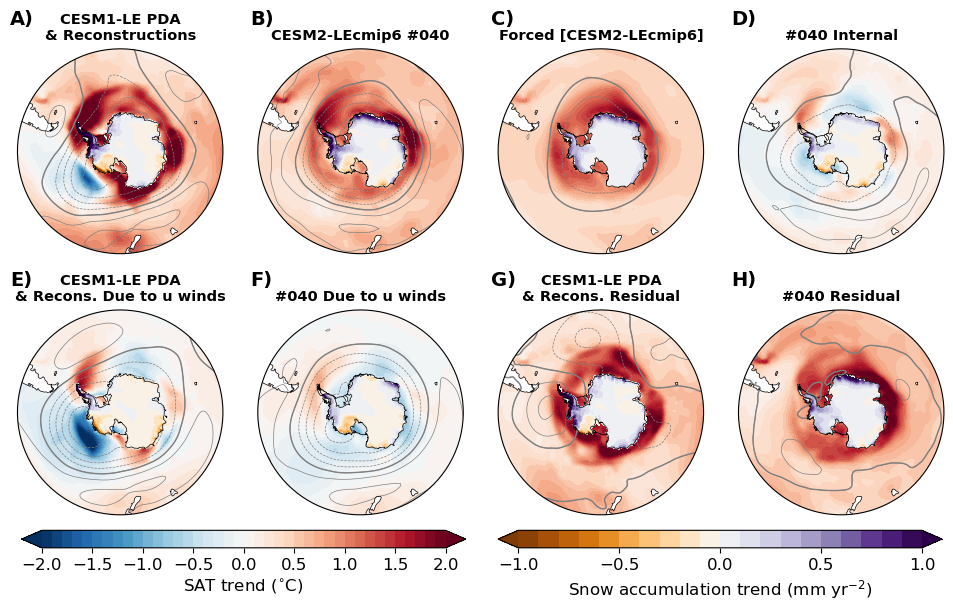

In [19]:
## 2x4
fig=plt.figure(figsize=(12,7))
gs=GridSpec(2,4)
plt.rcParams['axes.titlepad'] =14

level_SMB = np.arange(-1., 1.01, 0.1)
ticks_SMB = np.arange(-1., 1.01, 0.5)

level_SST = np.arange(-2., 2.01, 0.1)
ticks_SST = np.arange(-2., 2.01, 0.5)

level_PSL = np.arange(0-1*100, 0+1*100, 1)
level_PSL0 = np.arange(-100., 100.1, 100.)

size_title = 10.5
size_label = 12
size_tick = 12
size_text = 14
width_contour = 0.5

cmap1 = 'RdBu_r'
cmap2 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax1, -40)

ax1.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax1.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im1a = ax1.contourf(lon_OC_full, lat_OC, SAT_trend_OC21_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im1b = ax1.contourf(lon_MT_full, lat_MT, SMB_trend_MT_full/100, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im1c = ax1.contour(lon_OC_full, lat_OC, PSL_trend_OC24_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im1d = ax1.contour(lon_OC_full, lat_OC, PSL_trend_OC24_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)


ax1.text(-6500000, 7400000, 'A)', fontsize=size_text, fontweight='bold')
ax1.set_title('CESM1-LE PDA\n'
              '& Reconstructions', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot2 #########################
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax2, -40)

ax2.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im2a = ax2.contourf(lon_full, lat, SAT_trend_LE40_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im2b = ax2.contourf(lon_full, lat, SMB_trend_LE40_full/100, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im2c = ax2.contour(lon_full, lat, PSL_trend_LE40_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im2d = ax2.contour(lon_full, lat, PSL_trend_LE40_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax2.text(-6500000, 7400000, 'B)', fontsize=size_text, fontweight='bold')
ax2.set_title('CESM2-LEcmip6 #040', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot3 #########################
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax3, -40)

ax3.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im3a = ax3.contourf(lon_full, lat, slope_SAT_LE_1901_2000_full*100, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im3b = ax3.contourf(lon_full, lat, slope_SMB_LE_1901_2000_full, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im3c = ax3.contour(lon_full, lat, slope_PSL_LE_1901_2000_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im3d = ax3.contour(lon_full, lat, slope_PSL_LE_1901_2000_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax3.text(-6500000, 7400000, 'C)', fontsize=size_text, fontweight='bold')
ax3.set_title('Forced [CESM2-LEcmip6]', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot4 #########################
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax4, -40)

ax4.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im4a = ax4.contourf(lon_full, lat, SAT_trend_LE40_full-slope_SAT_LE_1901_2000_full*100, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im4b = ax4.contourf(lon_full, lat, SMB_trend_LE40_full/100-slope_SMB_LE_1901_2000_full, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im4c = ax4.contour(lon_full, lat, PSL_trend_LE40_full-slope_PSL_LE_1901_2000_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im4d = ax4.contour(lon_full, lat, PSL_trend_LE40_full-slope_PSL_LE_1901_2000_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax4.text(-6500000, 7400000, 'D)', fontsize=size_text, fontweight='bold')
ax4.set_title('#040 Internal', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot5 #########################
ax5 = plt.subplot(gs[4], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax5, -40)

ax5.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax5.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im5a = ax5.contourf(lon_OC_full, lat_OC, SAT_trend_OC21_u_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im5b = ax5.contourf(lon_MT_full, lat_MT, SMB_trend_MT_u_full/100, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im5c = ax5.contour(lon_OC_full, lat_OC, PSL_trend_OC24_u_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im5d = ax5.contour(lon_OC_full, lat_OC, PSL_trend_OC24_u_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax5.text(-6500000, 7400000, 'E)', fontsize=size_text, fontweight='bold')
ax5.set_title('CESM1-LE PDA\n'
              '& Recons. Due to u winds', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot6 #########################
ax6 = plt.subplot(gs[5], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax6, -40)

ax6.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax6.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im6a = ax6.contourf(lon_full, lat, SAT_trend_LE40_u_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im6b = ax6.contourf(lon_full, lat, SMB_trend_LE40_u_full/100, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im6c = ax6.contour(lon_full, lat, PSL_trend_LE40_u_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im6d = ax6.contour(lon_full, lat, PSL_trend_LE40_u_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax6.text(-6500000, 7400000, 'F)', fontsize=size_text, fontweight='bold')
ax6.set_title('#040 Due to u winds', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot7 #########################
ax7 = plt.subplot(gs[6], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax7, -40)

ax7.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax7.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im7a = ax7.contourf(lon_OC_full, lat_OC, SAT_trend_OC21_res_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im7b = ax7.contourf(lon_MT_full, lat_MT, SMB_trend_MT_res_full/100, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im7c = ax7.contour(lon_OC_full, lat_OC, PSL_trend_OC24_res_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im7d = ax7.contour(lon_OC_full, lat_OC, PSL_trend_OC24_res_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax7.text(-6500000, 7400000, 'G)', fontsize=size_text, fontweight='bold')
ax7.set_title('CESM1-LE PDA\n'
              '& Recons. Residual', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot8 #########################
ax8 = plt.subplot(gs[7], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax8, -40)

ax8.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax8.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im8a = ax8.contourf(lon_full, lat, SAT_trend_LE40_res_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im8b = ax8.contourf(lon_full, lat, SMB_trend_LE40_res_full/100, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im8c = ax8.contour(lon_full, lat, PSL_trend_LE40_res_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im8d = ax8.contour(lon_full, lat, PSL_trend_LE40_res_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax8.text(-6500000, 7400000, 'H)', fontsize=size_text, fontweight='bold')
ax8.set_title('#040 Residual', pad=8, fontsize=size_title, fontweight='bold')


#Colorbar
cbar1_ax = fig.add_axes([0.13, 0.17, 0.37, 0.025]) #[from left, from bottom, width, height]
cbar1 = fig.colorbar(im1a, cax=cbar1_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SST, ticks=ticks_SST)
cbar1.ax.tick_params(labelsize=size_tick)
cbar1.set_label('SAT trend ($^{\circ}$C)', size=size_label)

cbar2_ax = fig.add_axes([0.527, 0.17, 0.37, 0.025]) #[from left, from bottom, width, height]
cbar2 = fig.colorbar(im1b, cax=cbar2_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar2.ax.tick_params(labelsize=size_tick)
cbar2.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    bottom=0.22,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.3)
plt.savefig(
    'plot/F3_map_AIS_SMB_SAT_PSL_trend.jpg',
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #